### Imports

In [2]:
import pandas as pd
import numpy as np
import os
import shutil
import random
import cv2
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Reproducibility

This notebook contains dataset obtaining, data preparation and EDA. So there is no need for using Google Colab or Kaggle kernels (for GPU purposes) in this part. You can run all these cells locally.

### Dataset

The initial dataset, called **CNR-EXT**, is composed by images collected from November 2015 to February 2016 under various weather conditions by 9 cameras with different perspectives and angles of view. CNR-EXT captures different situations of light conditions, and it includes partial occlusion patterns due to obstacles (trees, lampposts, other cars) and partial or global shadowed cars.

You can download CNRPark+EXT using the following links:

* [CNRPark+EXT.csv](http://cnrpark.it/dataset/CNRPark+EXT.csv) (18.1 MB) - csv-file collecting metadata for each patch of both CNRPark and CNR-EXT datasets

* [CNR-EXT-Patches-150x150.zip](http://cnrpark.it/dataset/CNRPark-Patches-150x150.zip) (449.5 MB) - segmented images (patches) of parking spaces belonging to the CNR-EXT subset.

Files follow this organization:

`PATCHES/<WEATHER>/<CAPTURE_DATE>/camera<CAM_ID>/<W_ID>_<CAPTURE_DATE>_<CAPTURE_TIME>_C0<CAM_ID>_<SLOT_ID>.jpg`,

where:

>* `<WEATHER>` can be `SUNNY`, `OVERCAST` or `RAINY`,
>* `<CAPTURE_DATE>` is the zero-padded `YYYY-MM-DD` formatted capture date,
>* `<CAM_ID>` is the number of the camera, ranging `1`-`9`,
>* `<W_ID>` is a weather identifier, that can be `S`, `O` or `R`,
>* `<CAPTURE_TIME>` is the zero-padded 24-hour `HH.MM` formatted capture time,
>* `<SLOT_ID>` is a **global ID** given to the monitored slot; this can be used to uniquely identify a slot in the CNR-EXT dataset.

**E.g:** `PATCHES/SUNNY/2015-11-22/camera6/S_2015-11-22_09.47_C06_205.jpg`

The `LABELS` folder contains a list file for each split of the dataset used in our experiments. Each line in list files follow this format: `<IMAGE_PATH> <LABEL>`, where:

>* `<IMAGE_PATH>` is the path to a slot image,
>* `<LABEL>` is `0` for `empty`, `1` for `occupied`.
    
* [CNR-EXT_FULL_IMAGE_1000x750.tar](http://cnrpark.it/dataset/CNR-EXT_FULL_IMAGE_1000x750.tar) (1.1 GB) - full frames of the cameras belonging to the CNR-EXT subset. Images have been downsampled from 2592x1944 to 1000x750 due to privacy issues.

Files follow this organization:

`FULL_IMAGE_1000x750/<WEATHER>/<CAPTURE_DATE>/camera<CAM_ID>/<CAPTURE_DATE>_<CAPTURE_TIME>.jpg`,

where:

>* `<WEATHER>` can be`SUNNY`, `OVERCAST` or `RAINY`,
>* `<CAPTURE_DATE>` is the zero-padded `YYYY-MM-DD` formatted capture date,
>* `<CAM_ID>` is the number of the camera, ranging `1`-`9`,
>* `<CAPTURE_TIME` is the zero-padded 24-hour `HHMM` formatted capture time.

The archive contains also 9 CSV files (one per camera) containing the bounding boxes of each parking space with which patches have been segmented. Pixel coordinates of the bouding boxes refer to the 2592x1944 version of the image and need to be rescaled to match the 1000x750 version.

You can download these archives manually or use `wget` commands below.

In [3]:
DATA_DIR = '../data'
RAW_DATA = f'{DATA_DIR}/raw'
PROCESSED_DATA = f'{DATA_DIR}/processed'
TRAIN_DIR = f'{PROCESSED_DATA}/train'
VAL_DIR = f'{PROCESSED_DATA}/val'
IMAGE_SIZE = 150 # input image size
SEED = 42 # used to fix random_state
random.seed(SEED)

Download and extract full images of parking from the cameras.
> **Note:** You have to uncomment the 3 next cells to download and unpack the initial data.

In [4]:
#! wget http://cnrpark.it/dataset/CNR-EXT_FULL_IMAGE_1000x750.tar --directory-prefix=../data/raw
#! tar -xzvf ../data/raw/CNR-EXT_FULL_IMAGE_1000x750.tar -C ../data/raw

Download and extract images of the separate parking slots.

In [5]:
#! wget http://cnrpark.it/dataset/CNR-EXT-Patches-150x150.zip --directory-prefix=../data/raw
#! tar -xzvf ../data/raw/CNR-EXT-Patches-150x150.zip -C ../data/raw

Now download CSV-file containing metadata for each patch of the CNR-EXT dataset.

In [6]:
#! wget http://cnrpark.it/dataset/CNRPark+EXT.csv --directory-prefix=../data/raw

### Data preparation

The inital dataset contains 140k+ images of free or occupied parking slots in the `PATCHES` folder.

Now we need to split this data into train, validation and test parts and put it into `processed` folder. So, we are going to do this according to the below structure.

* raw
* processed
    * train
        * empty
        * occupied
    * val
        * empty
        * occupied
    * test
        * empty
        * occupied
*external

As you can see, we plan to make a train, validation and test folders.
In each folder, we create empty and occupied subfolders. Then we move all the images according to their reference in text files (in `LABELS` folder).

We can do all this steps manually or with Python (using `os` and `shutil` packages below).

In [7]:
column_names = ['image_path', 'class']
train_df = pd.read_csv(f'{RAW_DATA}/LABELS/train.txt', sep=' ', names=column_names, header=None)
val_df = pd.read_csv(f'{RAW_DATA}/LABELS/val.txt', sep=' ', names=column_names, header=None)
test_df = pd.read_csv(f'{RAW_DATA}/LABELS/test.txt', sep=' ', names=column_names, header=None)

In [8]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
overall = train_size + val_size + test_size
dataset_parts = {
    'data_type': ['train', 'val', 'test'],
    'count': [train_size, val_size, test_size],
    'part': [round(train_size / overall, 2), round(val_size / overall, 2), round(test_size / overall, 2)]
}
dataset_parts_df = pd.DataFrame.from_dict(dataset_parts)
dataset_parts_df

,data_type,count,part
0,train,94493,0.65
1,val,18647,0.13
2,test,31825,0.22


As we can see, the split distribution a little bit skewed. We have about 65% of train data, 13% for validation and also 22% for testing part. Now let's split initial dataset according to the given split distribution. 

In [10]:
# Create directories according to the folder structure above
dataset_parts = ['train', 'val', 'test']
class_names = ['empty', 'occupied']

for part in dataset_parts:
    for class_name in class_names:
        os.makedirs(os.path.join(PROCESSED_DATA, part, class_name), exist_ok=True, mode=0o777)

In [11]:
train_df['class'] = train_df['class'].apply(lambda x: 'occupied' if x == 1 else 'empty')
val_df['class'] = val_df['class'].apply(lambda x: 'occupied' if x == 1 else 'empty')
test_df['class'] = test_df['class'].apply(lambda x: 'occupied' if x == 1 else 'empty')

In [12]:
def copy_images(df: pd.DataFrame, data_type: str):
    """
    Copies images from source dir to destination.
    """
    for index, row in df.iterrows():
        src = os.path.join(RAW_DATA, 'PATCHES', row['image_path'])
        dest = os.path.join(PROCESSED_DATA, data_type, row['class'])
        shutil.copy(src, dest)

In [ ]:
copy_images(train_df, 'train')
copy_images(val_df, 'val')
copy_images(test_df, 'test')

### Exploratory data analysis (EDA)

EDA for Computer Vision tasks isn’t as straightforward as in classical ML, because the initial dataset isn't provided in a handy manner. But in our special case we can try to extract some useful information from our images and their text descriptions, and then make some analysis of it.

To avoid any data snooping, we put aside our test part and implement EDA over train and validation parts only. Let's first take a look at the text representations of our datasets.

In [11]:
train_df.head()

,image_path,class
0,SUNNY/2015-11-12/camera8/S_2015-11-12_12.26_C0...,occupied
1,OVERCAST/2015-11-25/camera8/O_2015-11-25_10.00...,occupied
2,OVERCAST/2015-12-19/camera4/O_2015-12-19_12.51...,empty
3,RAINY/2015-11-21/camera7/R_2015-11-21_13.18_C0...,empty
4,OVERCAST/2015-11-20/camera6/O_2015-11-20_11.17...,occupied


In [12]:
val_df.head()

,image_path,class
0,SUNNY/2016-01-15/camera5/S_2016-01-15_12.40_C0...,occupied
1,SUNNY/2016-01-15/camera7/S_2016-01-15_16.41_C0...,occupied
2,SUNNY/2016-01-15/camera1/S_2016-01-15_14.05_C0...,occupied
3,SUNNY/2016-01-15/camera6/S_2016-01-15_12.38_C0...,occupied
4,OVERCAST/2015-11-16/camera6/O_2015-11-16_11.47...,occupied


As `image_path` column contains some hidden insights, we can try to extract it. We will use `extract_info_from_df` function for such purposes.

In [13]:
def extract_info_from_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts extra information from the image path: weather, date, time, camera_id and parking slot_id.
    """
    df[['weather', 'date', 'camera_id', 'image']] = df['image_path'].str.split('/', expand=True)
    df[['_', '_', 'time', '_', 'slot_id']] = df['image'].str.split('_', expand=True)
    df['weather'] = df['weather'].str.lower()
    df['camera_id'] = df['camera_id'].str.replace('camera', '')
    df['time'] = df['time'].str.replace('.', ':')
    df['slot_id'] = df['slot_id'].str.replace('.jpg', '')    
    return df.drop(columns={'image_path', 'image', '_'})

In [14]:
# Save image_path to the separate variable and then extract the necessary info
train_image_path = train_df['image_path']
train_df = extract_info_from_df(train_df)
print(train_df.shape)
train_df.head()

(94493, 6)


,class,weather,date,camera_id,time,slot_id
0,occupied,sunny,2015-11-12,8,12:26,280
1,occupied,overcast,2015-11-25,8,10:00,212
2,empty,overcast,2015-12-19,4,12:51,195
3,empty,rainy,2015-11-21,7,13:18,247
4,occupied,overcast,2015-11-20,6,11:17,317


In [15]:
# Repeat the same steps for validation part
val_image_path = val_df['image_path']
val_df = extract_info_from_df(val_df)
print(val_df.shape)
val_df.head()

(18647, 6)


,class,weather,date,camera_id,time,slot_id
0,occupied,sunny,2016-01-15,5,12:40,274
1,occupied,sunny,2016-01-15,7,16:41,248
2,occupied,sunny,2016-01-15,1,14:05,607
3,occupied,sunny,2016-01-15,6,12:38,232
4,occupied,overcast,2015-11-16,6,11:47,205


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94493 entries, 0 to 94492
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class      94493 non-null  object
 1   weather    94493 non-null  object
 2   date       94493 non-null  object
 3   camera_id  94493 non-null  object
 4   time       94493 non-null  object
 5   slot_id    94493 non-null  object
dtypes: object(6)
memory usage: 4.3+ MB


In [17]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18647 entries, 0 to 18646
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class      18647 non-null  object
 1   weather    18647 non-null  object
 2   date       18647 non-null  object
 3   camera_id  18647 non-null  object
 4   time       18647 non-null  object
 5   slot_id    18647 non-null  object
dtypes: object(6)
memory usage: 874.2+ KB


There are no missing values in the both parts.

In [18]:
train_df.describe()

,class,weather,date,camera_id,time,slot_id
count,94493,94493,94493,94493,94493,94493
unique,2,3,15,9,566,164
top,occupied,sunny,2015-11-12,8,09:47,221
freq,47616,44232,6583,15714,696,1177


In [19]:
val_df.describe()

,class,weather,date,camera_id,time,slot_id
count,18647,18647,18647,18647,18647,18647
unique,2,2,3,9,315,164
top,occupied,overcast,2016-01-15,8,09:10,221
freq,13415,12301,6346,3078,163,229


In [20]:
val_df['weather'].unique()

array(['sunny', 'overcast'], dtype=object)

What we can notice from the above tables:
- all the features are seems to be categorical (and we also can apply some transforms to `date` and `time` columns);
- both dataset parts contain all the cameras and parking slots;
- valitaion part of the dataset doesn't contain images of the rainy weather;
- `date` and `time` columns of the validation part are less variable than the train one.

### Plot data

It's time to plot some charts.
Identifying target distribution is an easy first step. We are going to find the number of images from each class and plot them to easily identify any imbalance.

> **Note:** Imbalance in our dataset could affect on algorithm performance.

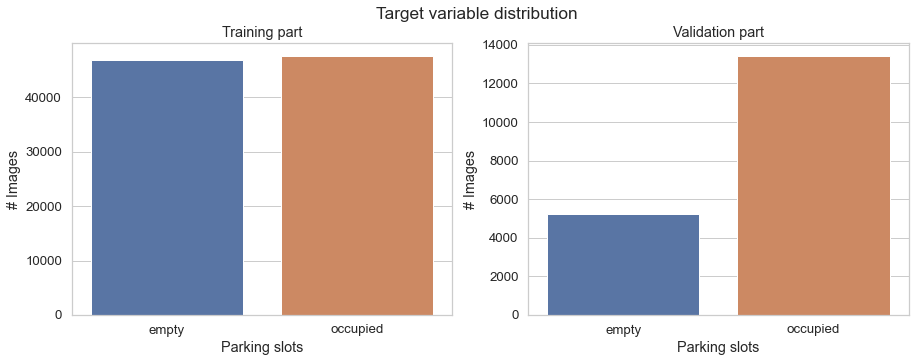

In [21]:
sns.set(style = "whitegrid" , font_scale = 1.2)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(train_df['class'], order=class_names, ax=ax[0])
ax[0].set_title('Training part')
sns.countplot(val_df['class'], order=class_names, ax=ax[1])
ax[1].set_title('Validation part')

for _ax in ax:
    _ax.set_xlabel('Parking slots')
    _ax.set_ylabel('# Images')
    
fig.suptitle('Target variable distribution')
plt.show()

In [22]:
train_df['class'].value_counts(normalize=True)

occupied    0.50391
empty       0.49609
Name: class, dtype: float64

In [23]:
val_df['class'].value_counts(normalize=True)

occupied    0.719419
empty       0.280581
Name: class, dtype: float64

Target label for the training part is pretty good balanced, while the distribution of the validation part is biased.

Now we can plot target distribution diagrams according to the specific parameters.

In [24]:
def plot_features(
    train_df: pd.DataFrame, 
    val_df: pd.DataFrame, 
    feature: str,
    rotation: int = 0,
    train_order: list[str] = None, 
    val_order: list[str] = None,
):
    if train_order is None:
        train_order = sorted(train_df[feature].unique())
    if val_order is None:
        val_order = sorted(val_df[feature].unique())
    
    target = 'class'
    sns.set(style = "whitegrid" , font_scale = 1.2)
    fig, ax = plt.subplots(2, 2, figsize=(14, 10))

    sns.countplot(train_df[feature], order=train_order, ax=ax[0][0])
    ax[0][0].set_title('Training part')

    sns.countplot(val_df[feature], order=val_order, ax=ax[0][1])
    ax[0][1].set_title('Validation part')

    for _ax in ax[0]:
        _ax.set_xlabel(feature.capitalize())
        _ax.set_ylabel('# Images')
        _ax.tick_params(axis='x', rotation=rotation)

    train_perc_df = train_df[feature].groupby(train_df[target]) \
        .value_counts(normalize=True).reset_index(name="percentage")
    sns.barplot(
        x=feature, 
        y='percentage',
        hue=target,
        data=train_perc_df,
        order=train_order,
        ax=ax[1][0], 
    )
    ax[1][0].set_title('Training part')

    val_perc_df = val_df[feature].groupby(val_df[target]) \
        .value_counts(normalize=True).reset_index(name="percentage")
    sns.barplot(
        x=feature, 
        y='percentage',
        hue=target,
        data=val_perc_df,
        order=val_order,
        ax=ax[1][1], 
    )
    ax[1][1].set_title('Validation part')

    for _ax in ax[1]:
        _ax.set_xlabel(feature.capitalize())
        _ax.set_ylabel('Percentage')
        _ax.tick_params(axis='x', rotation=rotation)

    fig.suptitle(f'Image distribution according to the {feature} parameter')
    fig.tight_layout()

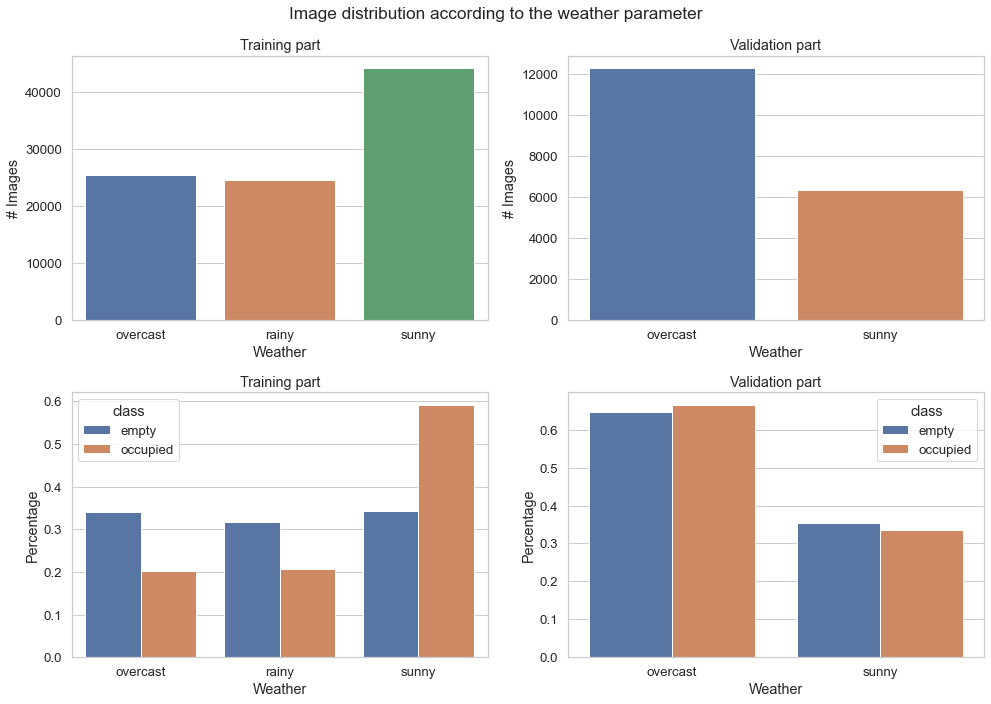

In [25]:
plot_features(train_df, val_df, 'weather')

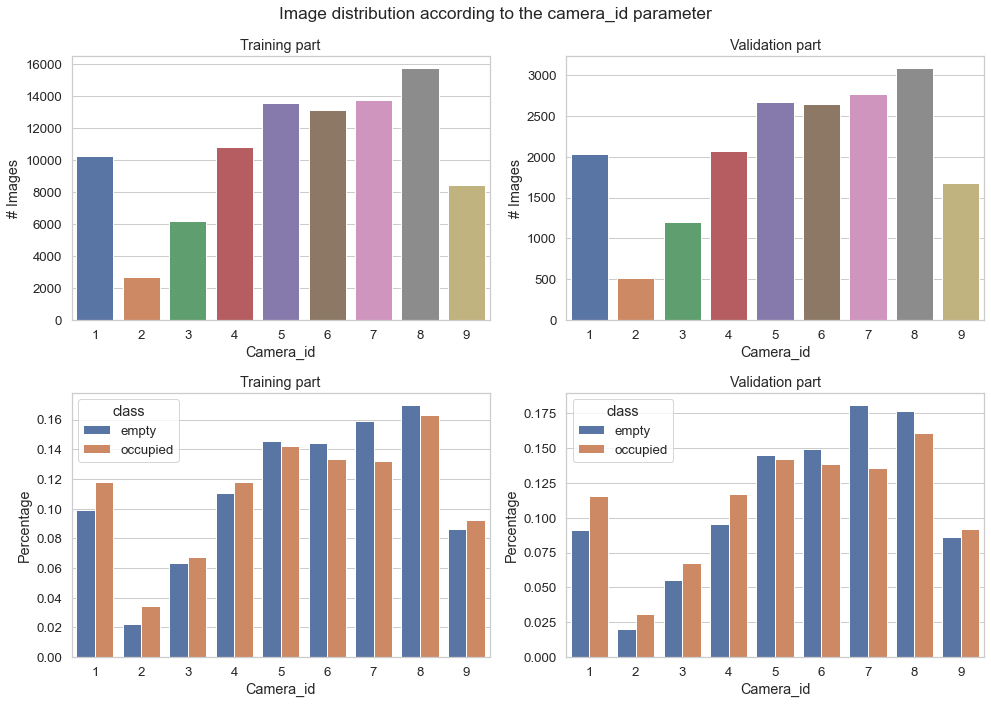

In [26]:
plot_features(train_df, val_df, 'camera_id')

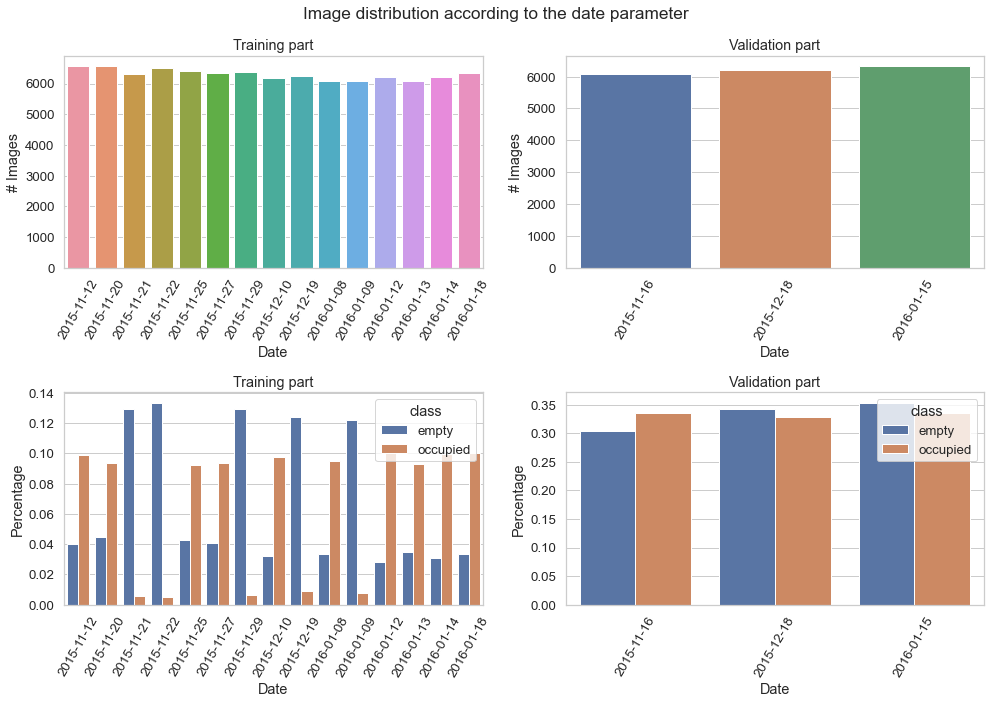

In [27]:
plot_features(train_df, val_df, 'date', rotation=60)

You can see that:
1) We have approximately the same number of images for each date, both for the train and validation parts. In this case, we can say they have a uniform distribution. But if we pay attention to the chart of the images distribution by dates according to the target variable for training data, we will find out that it contains a sequence of alternating peaks. We can guess that there is some reason behind this.
2) Validation data contains images for only 3 days.

Now we will try to extract and analyze the following features from the `date` column:
* day number,
* name of the day;
* name of the month.

In [28]:
train_df['day'] = pd.to_datetime(train_df['date'], format='%Y-%m-%d').dt.day
train_df['day_of_week'] = pd.to_datetime(train_df['date'], format='%Y-%m-%d').dt.day_name()
train_df['month'] = pd.to_datetime(train_df['date'], format='%Y-%m-%d').dt.month_name()

val_df['day'] = pd.to_datetime(val_df['date'], format='%Y-%m-%d').dt.day
val_df['day_of_week'] = pd.to_datetime(val_df['date'], format='%Y-%m-%d').dt.day_name()
val_df['month'] = pd.to_datetime(val_df['date'], format='%Y-%m-%d').dt.month_name()

In [29]:
train_df.head()

,class,weather,date,camera_id,time,slot_id,day,day_of_week,month
0,occupied,sunny,2015-11-12,8,12:26,280,12,Thursday,November
1,occupied,overcast,2015-11-25,8,10:00,212,25,Wednesday,November
2,empty,overcast,2015-12-19,4,12:51,195,19,Saturday,December
3,empty,rainy,2015-11-21,7,13:18,247,21,Saturday,November
4,occupied,overcast,2015-11-20,6,11:17,317,20,Friday,November


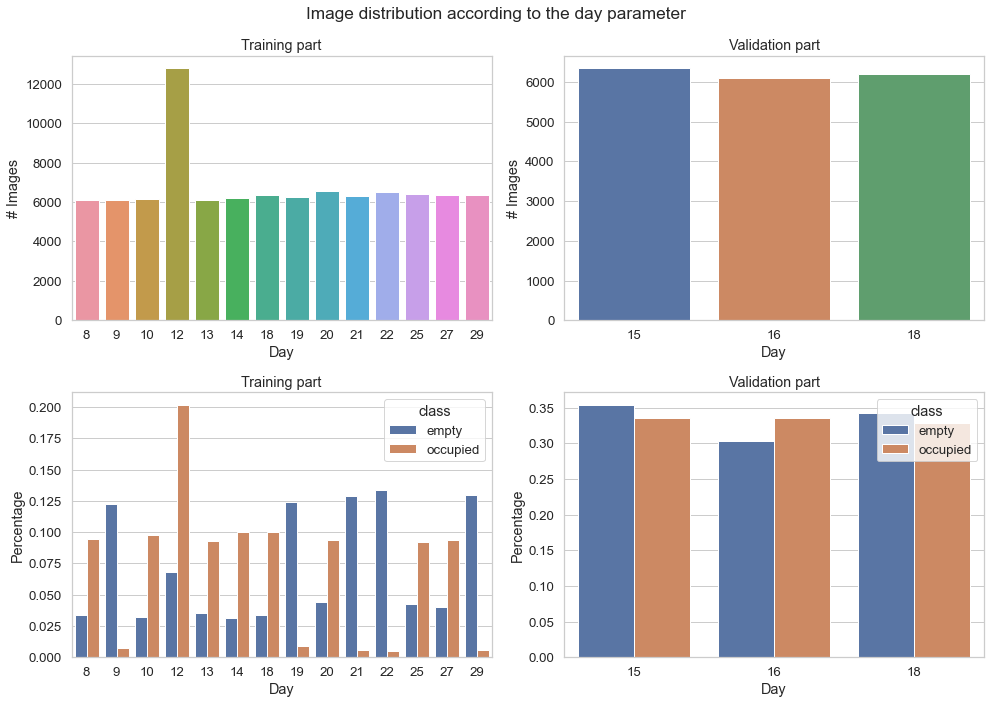

In [30]:
plot_features(train_df, val_df, 'day')

All images are distributed equally, except of day of 12 in the training data.

In [31]:
print(train_df['day_of_week'].unique())
print(val_df['day_of_week'].unique())

['Thursday' 'Wednesday' 'Saturday' 'Friday' 'Sunday' 'Tuesday' 'Monday']
['Friday' 'Monday']


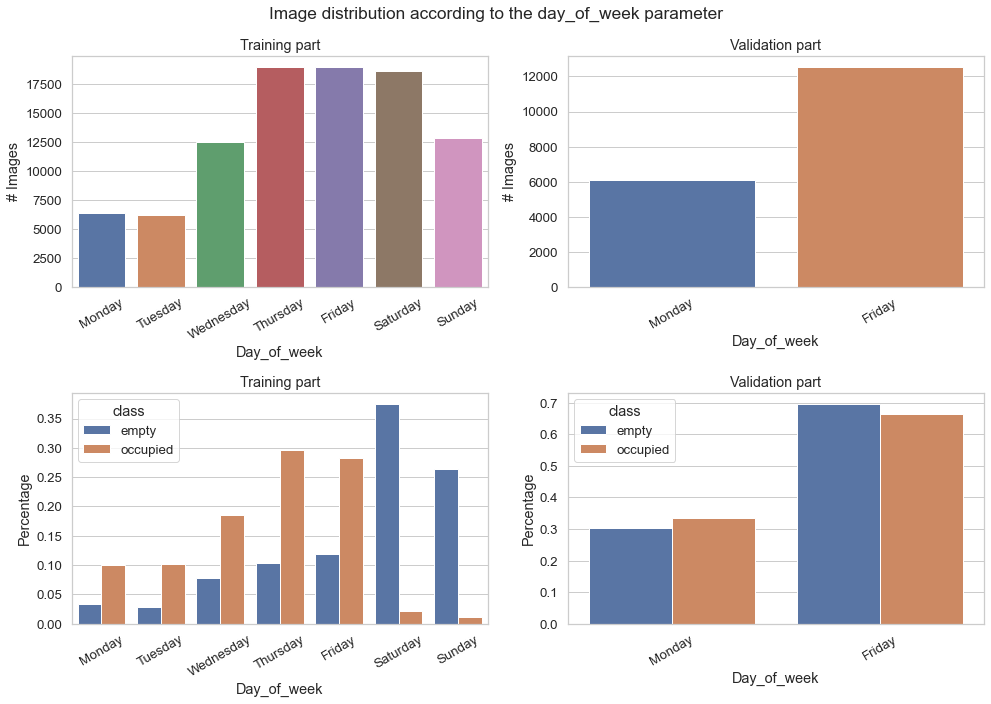

In [32]:
train_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
val_order = ['Monday', 'Friday']
plot_features(train_df, val_df, 'day_of_week', 30, train_order, val_order)

Validation data contains only Monday and Friday images. We have to keep this in mind.

By the way, the diagrams for the `day_of_week` parameter can help us to understand the nature of the peaks we get on charts earlier. On the distribution in the bottom-left peace, we see that parking slots are mostly occupied during the work week, and on the weekends the number of free spaces is drastically increases. This could explained by the fact that these cameras were installed on the public city parking or near some company's office. And people use their cars to get to the office on weekdays. We can also check it if we look at the charts for the `day` column.  Such days as 9, 19, 21, 22, 29 fell on weekends.

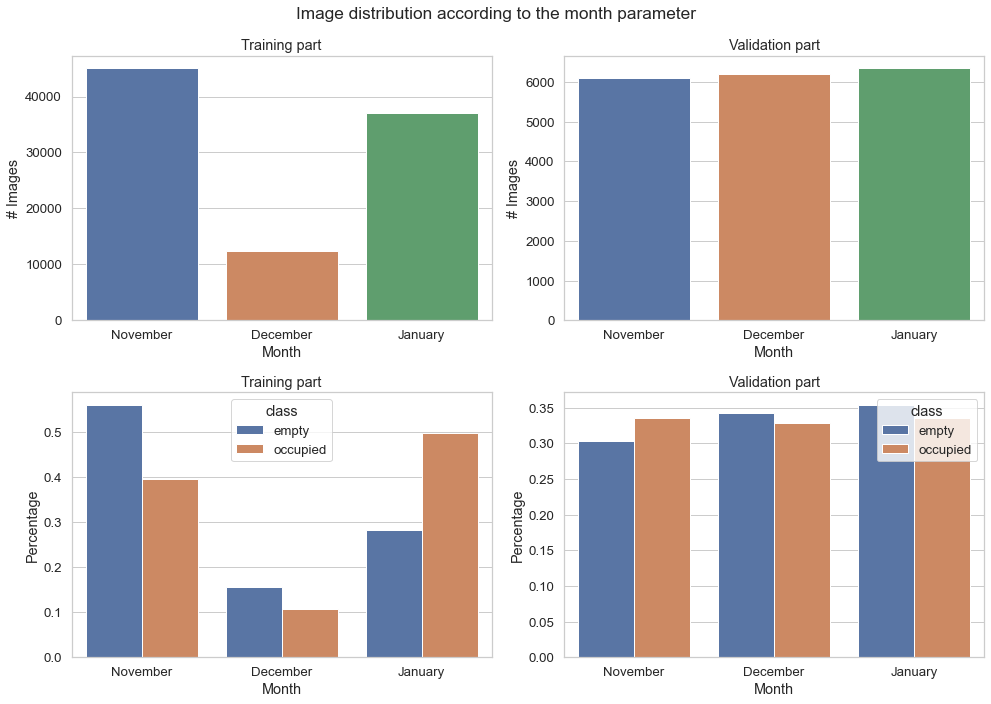

In [33]:
train_order = ['November', 'December', 'January']
val_order = ['November', 'December', 'January']
plot_features(train_df, val_df, 'month', 0, train_order, val_order)

In case of the `month` column, we should notice some imbalance for the training data, while the validation part is distributed uniformly.

Next is the `time` column. We don't need to build charts for this column, as it contains a large number of different values. Instead, we can extract information about the hour and then plot diagrams for it.

In [34]:
train_df['hour'] = pd.to_datetime(train_df['time'], format='%H:%M').dt.hour
val_df['hour'] = pd.to_datetime(val_df['time'], format='%H:%M').dt.hour

In [35]:
train_df.head()

,class,weather,date,camera_id,time,slot_id,day,day_of_week,month,hour
0,occupied,sunny,2015-11-12,8,12:26,280,12,Thursday,November,12
1,occupied,overcast,2015-11-25,8,10:00,212,25,Wednesday,November,10
2,empty,overcast,2015-12-19,4,12:51,195,19,Saturday,December,12
3,empty,rainy,2015-11-21,7,13:18,247,21,Saturday,November,13
4,occupied,overcast,2015-11-20,6,11:17,317,20,Friday,November,11


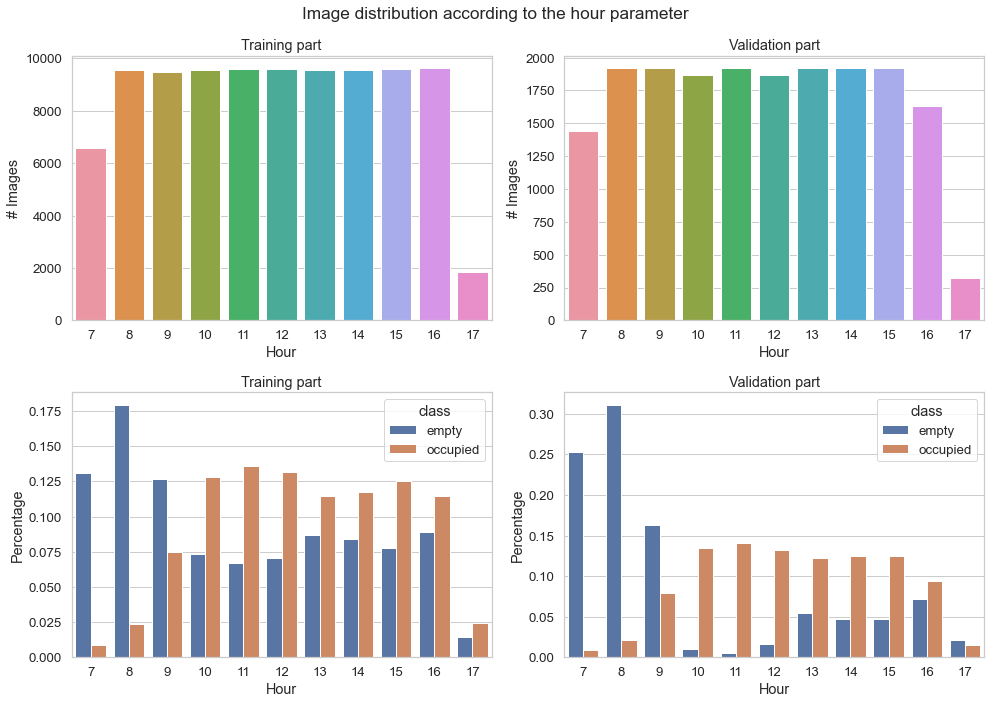

In [36]:
plot_features(train_df, val_df, 'hour')

The distribution of the train and validation parts looks the same. And we can also mention that there are a lot of empty parking slots at earlier hours. 

And the last thing we will do with the text data is to find out the most frequent parking slots in the dataset. And we can make sure that the top 10 common slots for the training dataset and the validation one are practically the same.

In [37]:
train_slot_top10 = train_df['slot_id'].value_counts().head(10)
pd.DataFrame({'slot_id': train_slot_top10.index, 'count': train_slot_top10}).reset_index(drop=True)

,slot_id,count
0,221,1177
1,274,892
2,276,892
3,312,892
4,275,892
5,310,892
6,309,892
7,311,892
8,316,888
9,313,888


In [38]:
val_slot_top10 = val_df['slot_id'].value_counts().head(10)
pd.DataFrame({'slot_id': val_slot_top10.index, 'count': val_slot_top10}).reset_index(drop=True)

,slot_id,count
0,221,229
1,274,178
2,309,178
3,310,178
4,312,178
5,311,178
6,276,178
7,275,178
8,315,177
9,314,177


Now it's time to switch to the images and make some research over them.

The basic steps that we can try:
* load and visualize raw images to better understand our dataset;
* inspect basic dataset statistics such as images size (widths and heights) or aspect ratios that will help us to determine what to do next (images preprocessing, apply augmentation, tune model parameters etc.);
* plot bounding or anchor boxes, if we are dealing with the problem of objects detection/segmentation.

Let's have a look at examples of each case at first.

In [39]:
def plot_image_samples(img_dir: str, title: str, count: int = 5):
    """
    Plots image samples from provided directory.
    """
    class_names = ['empty', 'occupied']

    # Get the list of .jpg files from sub image class folders
    empty_imgs = [
        img_path for img_path in os.listdir(os.path.join(img_dir, 'empty')) 
        if img_path.endswith('.jpg')
    ]
    occupied_imgs = [
        img_path for img_path in os.listdir(os.path.join(img_dir, 'occupied')) 
        if img_path.endswith('.jpg')
    ]

    # Select random images from each class
    empty_list = np.random.choice(empty_imgs, count, replace = False)
    occupied_list = np.random.choice(occupied_imgs, count, replace = False)

    nrows = 2
    ncols = count
    fig, axes = plt.subplots(nrows, ncols, figsize=(count * 3 - 1, 6))
    for i in range(2):
        for idx, ax in enumerate(axes[i]):
            if not i:
                img_path = os.path.join(img_dir, class_names[i], empty_list[idx])
            else:
                img_path = os.path.join(img_dir, class_names[i], occupied_list[idx]) 
            label = class_names[i].capitalize()
            img = image.load_img(img_path, color_mode='rgb')
            ax.imshow(img)
            ax.set_title(label)
            ax.axis('off')
    fig.suptitle(title);

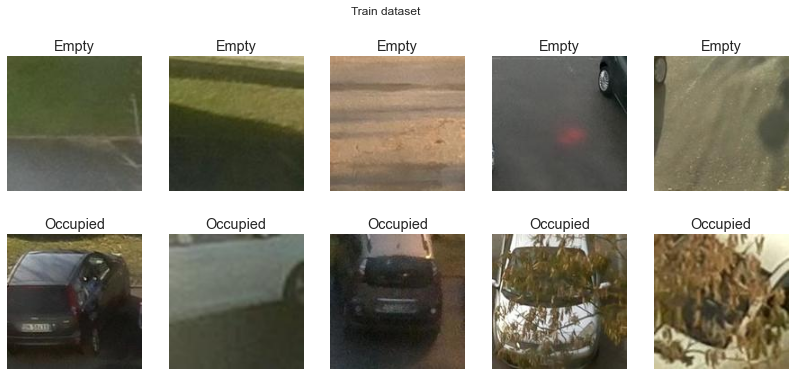

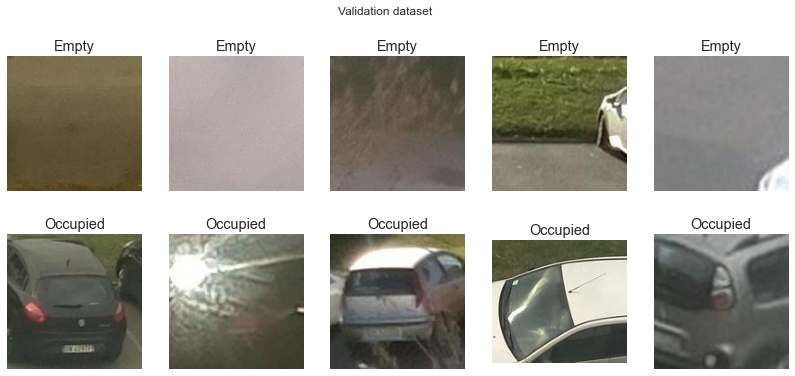

In [44]:
plot_image_samples(TRAIN_DIR, 'Train dataset')
plot_image_samples(VAL_DIR, 'Validation dataset')

In our case, there is no need to analyze the sizes and ratios of images, because all patches have the same size of `(150, 150)`. But this doesn't mean that we have nothing more to research on.

Next, we can use some techniques described in [this article](https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2) to plot average images of each class.

To compute the average image, we can take the average value of each pixel across all observations. We will use two functions to calculate and plot these average values. As the initial dataset is too large, we going to take only subsample from the training dataset.

In [45]:
def image_to_matrix(path: str, img_list: list[str], size = (128, 128)) -> np.ndarray:
    """
    Converts image into numpy matrix representation.
    """
    full_mat = None
    for img in img_list:
        img_path = path + img
        current_img = image.load_img(img_path, target_size = size, 
                                     color_mode = 'grayscale')
        img_mat = image.img_to_array(current_img)

        img_mat = [img_mat.ravel()]
        if full_mat is None:
            full_mat = img_mat
        else:
            full_mat = np.concatenate((full_mat, img_mat))
            
    return full_mat

def get_mean_image(full_mat: np.ndarray, title: str, size = (128, 128)) -> np.ndarray:
    """
    Calculates and returns average image.
    """
    mean_img = np.mean(full_mat, axis = 0)
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    
    return mean_img

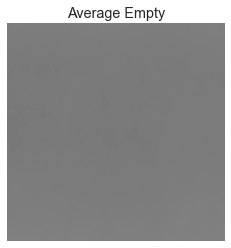

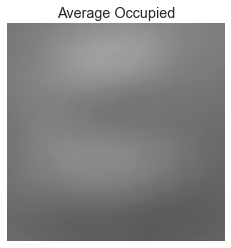

In [52]:
sample_size = 3000 # subsample size

empty_imgs = [
    img_path for img_path in os.listdir(os.path.join(TRAIN_DIR, 'empty')) 
    if img_path.endswith('.jpg')
]
occupied_imgs = [
    img_path for img_path in os.listdir(os.path.join(TRAIN_DIR, 'occupied')) 
    if img_path.endswith('.jpg')
]
empty_sample = np.random.choice(empty_imgs, sample_size, replace = False)
occupied_sample = np.random.choice(occupied_imgs, sample_size, replace = False)
empty_images = image_to_matrix(f'{TRAIN_DIR}/empty/', empty_sample, (IMAGE_SIZE, IMAGE_SIZE))
occupied_images = image_to_matrix(f'{TRAIN_DIR}/occupied/', occupied_sample, (IMAGE_SIZE, IMAGE_SIZE))

empty_mean = get_mean_image(empty_images, 'Empty', (IMAGE_SIZE, IMAGE_SIZE))
occupied_mean = get_mean_image(occupied_images, 'Occupied', (IMAGE_SIZE, IMAGE_SIZE))

We can see from the average images that the occupied slots contain certain shapes of the car.

Using the average images, we can also compute the difference between them.

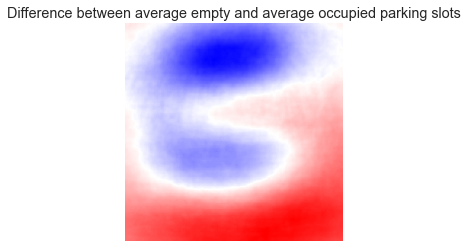

In [53]:
diff_mean = empty_mean - occupied_mean
plt.imshow(diff_mean, cmap='bwr')
plt.title(f'Difference between average empty and average occupied parking slots')
plt.axis('off')
plt.show()

Except of patches and labels of the parking slots, our dataset also contains full frames of the cameras with CSV files (one per camera) containing the bounding boxes of each parking space with which patches have been segmented. Therefore, we can try to plot a couple of such frames with bounding boxes of parking slots.

> **Note:**  Pixel coordinates of the bouding boxes refer to the 2592x1944 version of the image and need to be rescaled to match the 1000x750 version. Hence, we have to define a special coefficient `COEFF` that we will use to correct the original coordinates of the bounding boxes.

In [54]:
COEFF = 1000.0 / 2592

In [55]:
def plot_sample_frame(img_path: str, bbox_path: str, cam_id: str):
    plt.figure(figsize = (16, 10))
    img = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bounding_boxes = pd.read_csv(bbox_path)

    for idx, bbox in bounding_boxes.iterrows():
        x1 = int(bbox.X * COEFF)
        y1 = int(bbox.Y * COEFF)
        x2 = int((bbox.X + bbox.W) * COEFF)
        y2 = int((bbox.Y + bbox.H) * COEFF)
        cv2.rectangle(rgb_img, (x1, y1), (x2, y2), color=(255, 255, 0), thickness=2)
        cv2.putText(rgb_img, 'Id:' + str(bbox.SlotId), (x1 + 5, y1 + 15), 0, fontScale=0.5, color=(255, 255, 0), thickness=2)
        
    plt.axis('off')
    plt.title(f'Camera {cam_id}')
    plt.imshow(rgb_img)

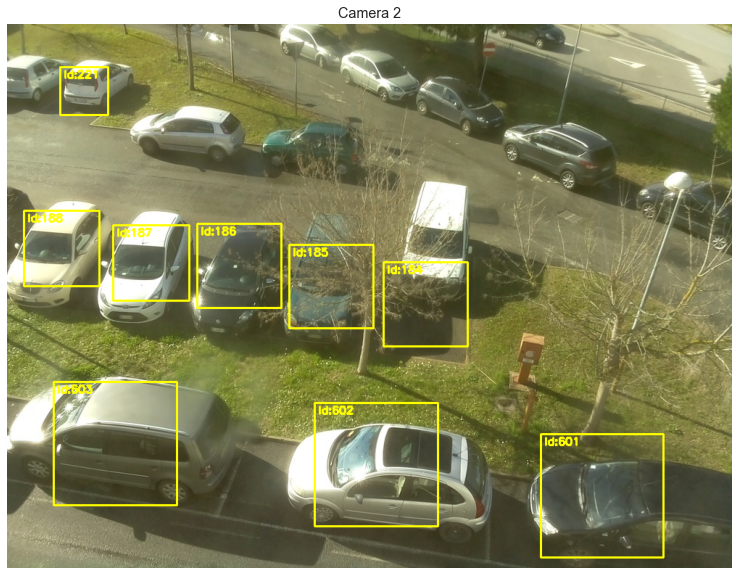

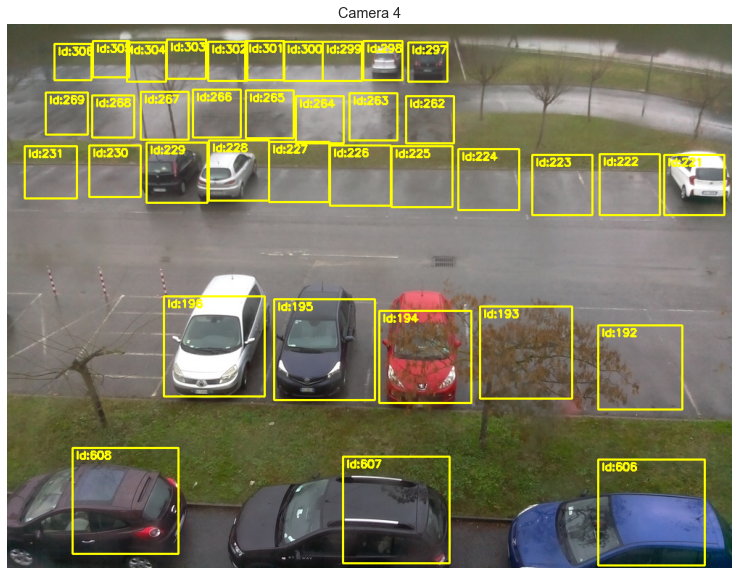

In [56]:
NUM = 2
for _ in range(NUM):
    CAMERA_ID = random.randint(1, 9)
    WEATHER = random.choice(['RAINY', 'SUNNY', 'OVERCAST'])
    WEATHER_PATH = os.path.join(RAW_DATA, 'FULL_IMAGE_1000x750', WEATHER)
    IMAGE_DATE = random.choice(os.listdir(WEATHER_PATH))
    IMAGE_NAME = random.choice(os.listdir(os.path.join(WEATHER_PATH, IMAGE_DATE, 'camera' + str(CAMERA_ID))))
    IMAGE_PATH = os.path.join(WEATHER_PATH, IMAGE_DATE, 'camera' + str(CAMERA_ID), IMAGE_NAME)
    BBOX_PATH = os.path.join(RAW_DATA, 'camera' + str(CAMERA_ID) + '.csv')
    plot_sample_frame(IMAGE_PATH, BBOX_PATH, CAMERA_ID)

As you see, there is a different set of bounding boxes for each camera. This means that each camera can only track its own set of parking slots (assigned to it in CSV file).